In [18]:
!pip install datasets pandas matplotlib seqeval -q


In [19]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json 
from datasets import load_dataset
import seqeval
from seqeval.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score      
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')


# Analyse des jeux de données 

In [28]:
def plot_class_distribution(dataset_name, label_col='ner_tags', splits=['train', 'validation', 'test'], plot=False):
    """Analyse la distribution des classes pour un dataset NER"""
    try:
        dataset = load_dataset(dataset_name, trust_remote_code=True)
    except Exception as e:
        print(f"Erreur: {e}")
        return

    results = {}
    
    for split in splits:
        if split not in dataset:
            continue
            
        # Extraction des labels
        all_labels = []
        for example in dataset[split]:
            labels = [l for l in example[label_col] if l != -100]
            
            if isinstance(labels[0], int):
                label_names = dataset[split].features[label_col].feature.names
                labels = [label_names[l] for l in labels]
                
            all_labels.extend(labels)

        # Calcul des stats
        counter = Counter(all_labels)
        total = sum(counter.values())
        
        # Création du DataFrame
        df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
        df['percentage'] = round((df['count']/total)*100, 2)
        df = df.sort_values('percentage', ascending=False)
        
        results[split] = df
        if plot:
            # Plot
            plt.figure(figsize=(12, 5))
            df.head(15).plot(kind='bar', y='percentage', title=f'{dataset_name} - {split}')
            plt.xticks(rotation=45, ha='right')
            plt.ylabel('% of total')
            plt.show()


    return results

In [29]:
conll_stats = plot_class_distribution('conll2003')
conll_stats

{'train':          count  percentage
 O       169578       83.28
 B-LOC     7140        3.51
 B-PER     6600        3.24
 B-ORG     6321        3.10
 I-PER     4528        2.22
 I-ORG     3704        1.82
 B-MISC    3438        1.69
 I-MISC    1155        0.57
 I-LOC     1157        0.57,
 'validation':         count  percentage
 O       42759       83.25
 B-PER    1842        3.59
 B-LOC    1837        3.58
 B-ORG    1341        2.61
 I-PER    1307        2.54
 B-MISC    922        1.80
 I-ORG     751        1.46
 I-MISC    346        0.67
 I-LOC     257        0.50,
 'test':         count  percentage
 O       38323       82.53
 B-LOC    1668        3.59
 B-ORG    1661        3.58
 B-PER    1617        3.48
 I-PER    1156        2.49
 I-ORG     835        1.80
 B-MISC    702        1.51
 I-LOC     257        0.55
 I-MISC    216        0.47}

In [30]:
medmentions_stats = plot_class_distribution('ibm-research/MedMentions-ZS')

In [27]:
medmentions_stats   

{'train':          count  percentage
 O       515420       73.52
 B-T038   25007        3.57
 B-T103   22360        3.19
 I-T038   15708        2.24
 B-T058   14779        2.11
 I-T103   14011        2.00
 B-T017   12575        1.79
 I-T058   12088        1.72
 B-T033    9824        1.40
 B-T082    7511        1.07
 I-T017    7474        1.07
 I-T033    6432        0.92
 B-T170    5996        0.86
 B-T062    5445        0.78
 I-T170    5118        0.73
 B-T204    4922        0.70
 I-T062    4392        0.63
 B-T098    3574        0.51
 I-T082    2998        0.43
 I-T204    2360        0.34
 B-T074    1165        0.17
 I-T074    1030        0.15
 I-T098     881        0.13,
 'validation':         count  percentage
 O       34400       92.23
 I-T092    478        1.28
 B-T092    452        1.21
 B-T037    434        1.16
 B-T201    404        1.08
 I-T201    236        0.63
 B-T005    224        0.60
 I-T037    225        0.60
 B-T091    196        0.53
 I-T091    124        0.33
 I-T005

In [ ]:
# 1. Identification des classes manquantes
tui_list = pd.read_csv("umls/tui_list.csv")["tui"]
try:
    dataset = load_dataset('ibm-research/MedMentions-ZS', trust_remote_code=True)
except Exception as e:
    print(f"Erreur: {e}")

split = ['train', 'validation', 'test']
for s in split:
    if s not in dataset:
        continue
    print(f'{s} : {len(dataset[s])}')
        
    # print(dataset['train'][0]['ner_tags'])
    dataset_ner_tags = [dataset[s][i]['ner_tags'] for i in range(len(dataset[s]))]
    dataset_ner_tags = [item for sublist in dataset_ner_tags for item in sublist]
    dataset_tuis = set(dataset_ner_tags)
    # print(f"Nombre de classes dans le dataset : {len(dataset_ner_tags)}")

    missing_tuis = set(tui_list) - dataset_tuis

    if len(missing_tuis) > 0:
        print(f"/!\\ {len(missing_tuis)} TUIs manquants : {missing_tuis}")



train : 26770
/!\ 127 TUIs manquants : {'T120', 'T093', 'T063', 'T044', 'T057', 'T204', 'T040', 'T046', 'T101', 'T055', 'T116', 'T081', 'T001', 'T002', 'T011', 'T125', 'T024', 'T073', 'T047', 'T020', 'T043', 'T045', 'T033', 'T100', 'T127', 'T069', 'T048', 'T103', 'T065', 'T051', 'T168', 'T039', 'T054', 'T061', 'T122', 'T109', 'T114', 'T192', 'T072', 'T079', 'T191', 'T014', 'T018', 'T197', 'T023', 'T085', 'T129', 'T171', 'T195', 'T015', 'T052', 'T104', 'T123', 'T042', 'T078', 'T074', 'T131', 'T030', 'T066', 'T126', 'T099', 'T029', 'T050', 'T201', 'T190', 'T019', 'T071', 'T086', 'T025', 'T021', 'T185', 'T058', 'T070', 'T080', 'T096', 'T049', 'T060', 'T026', 'T062', 'T017', 'T094', 'T008', 'T053', 'T194', 'T004', 'T064', 'T169', 'T203', 'T059', 'T087', 'T075', 'T041', 'T170', 'T028', 'T097', 'T012', 'T022', 'T088', 'T067', 'T077', 'T095', 'T005', 'T167', 'T102', 'T089', 'T034', 'T121', 'T013', 'T130', 'T200', 'T038', 'T083', 'T082', 'T092', 'T196', 'T007', 'T098', 'T068', 'T010', 'T016', 

## Partitions équilibrées

In [106]:
!pip install scikit-multilearn -q
!pip show

In [9]:
from datasets import load_dataset
from datasets import concatenate_datasets
from skmultilearn.model_selection import IterativeStratification
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from collections import defaultdict

In [10]:

# Charger et combiner les données
try:
    dataset = load_dataset('ibm-research/MedMentions-ZS', trust_remote_code=True)
except Exception as e:
    print(f"Erreur: {e}")
combined = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])


In [16]:

# Extraire les TUIs
tuis_per_doc = []
for doc in combined: 
    tuis_per_doc.append(set(doc['ner_tags']))
    
print(len(tuis_per_doc))



29107


In [20]:

# Créer le mapping TUI vers indice
all_tuis = list({tui for tuis in tuis_per_doc for tui in tuis})
tui_to_idx = {tui: idx for idx, tui in enumerate(all_tuis)}


In [ ]:
from datasets import load_dataset
from datasets import DatasetDict
from skmultilearn.model_selection import IterativeStratification
from skmultilearn.model_selection import iterative_train_test_split
from scipy.sparse import csr_matrix
import numpy as np

def balanced_split(dataset, ratios=[0.8, 0.1, 0.1], seed=42):
    """
    Effectue un split stratifié multi-label selon les ratios spécifiés
    Args:
        dataset: Dataset HuggingFace à splitter (combinée)
        ratios: Liste de 3 proportions [train, val, test] qui doivent sommer à 1
        seed: Seed pour la randomisation
    Returns:
        Tuple de 3 datasets (train, val, test)
    """
    # Validation des paramètres
    dataset_combined = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])


    np.random.seed(seed)

    assert len(ratios) == 3, "Doit spécifier 3 ratios"
    assert abs(sum(ratios) - 1.0) < 1e-6, "Les ratios doivent sommer à 1"
    
    # Extraire les TUIs
    print("Extraction des NER-Tags...")
    tuis_per_doc = []
    for doc in dataset_combined: 
        tuis_per_doc.append(set(doc['ner_tags']))
    print("Fait!")
    # print(len(tuis_per_doc))

    print("Création du mapping TUI vers indice...")
    # Créer le mapping TUI vers indice
    all_tuis = sorted({tui for tuis in tuis_per_doc for tui in tuis})
    tui_to_idx = {tui: idx for idx, tui in enumerate(all_tuis)}


    num_docs = len(dataset_combined)
    num_tuis = len(all_tuis)
    
    row_indices = []
    col_indices = []
    for doc_idx, tuis in enumerate(tuis_per_doc):
        for tui in tuis:
            row_indices.append(doc_idx)
            col_indices.append(tui_to_idx[tui])

    label_matrix = csr_matrix((np.ones(len(row_indices)), 
                            (row_indices, col_indices)), 
                            shape=(num_docs, num_tuis))

    print("Fait!")

    indices = np.arange(len(dataset_combined))  

    print("Shuffle des indices avant le split...")
    np.random.shuffle(indices)  # Mélange les indices des documents
    label_matrix = label_matrix[indices]  # Applique le même shuffle aux labels
    print("Fait!")

    print("Création du premier split (train VS reste)...")
    # Premier split: train vs temp (val+test)
    train_ratio = ratios[0]
    X_train, Y_train, X_temp, Y_temp = iterative_train_test_split(
        indices.reshape(-1, 1), 
        label_matrix, 
        test_size=1-train_ratio
    )
    
    print("Fait!")
    print("Création du deuxième split (val VS test)...")
    # Deuxième split: val vs test
    val_ratio = ratios[1]/(1 - train_ratio)
    X_val, Y_val, X_test, Y_test = iterative_train_test_split(
        X_temp,
        Y_temp,
        test_size=1-val_ratio
    )
    print("Fait!")

    print("Conversion des indices...")
    # Convertir les indices
    train_indices = np.setdiff1d(indices, X_temp.flatten())
    val_indices = X_val.flatten()
    test_indices = X_test.flatten()
    print("Fait! ")

    # Vérifier les overlaps
    assert len(set(train_indices) & set(val_indices)) == 0, "Overlap entre train et val"
    assert len(set(train_indices) & set(test_indices)) == 0, "Overlap entre train et test"
    assert len(set(val_indices) & set(test_indices)) == 0, "Overlap entre val et test"

    # Vérifier que tous les exemples sont dans au moins un split
    assert len(set(train_indices) | set(val_indices) | set(test_indices)) == len(dataset_combined), "Certains exemples ne sont pas dans un split"

    print("Tous les exemples sont dans un split! et sans overlaps.")
    print("Stratification terminée!")
    return DatasetDict({
        "train": dataset_combined.select(train_indices),
        "validation": dataset_combined.select(val_indices),
        "test": dataset_combined.select(test_indices)
    })

# Charger et combiner les données
try:
    dataset = load_dataset('ibm-research/MedMentions-ZS', trust_remote_code=True)
    print(dataset.keys())
except Exception as e:
    print(f"Erreur: {e}")
# combined = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])


# Paramètres personnalisables ici
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

new_dataset = stratified_split(
    dataset,
    # ratios=[train_ratio, val_ratio, test_ratio], 
    seed=42
)


dict_keys(['train', 'validation', 'test'])
Extraction des NER-Tags...
Fait!
Création du mapping TUI vers indice...
Fait!
Shuffle des indices avant le split...
Fait!
Création du premier split (train VS reste)...
Fait!
Création du deuxième split (val VS test)...
Fait!
Conversion des indices...
Fait! 
Tous les exemples sont dans un split! et sans overlaps.
Stratification terminée!


In [108]:

train_dataset, val_dataset, test_dataset = new_dataset['train'], new_dataset['validation'], new_dataset['test']


In [109]:
def check_dataset_structure(original_dataset, new_dataset):
    """
    Vérifie que la structure des datasets est identique entre le dataset d'origine et celui produit
    (même colonnes et types de données).
    Args:
        original_dataset: Le dataset d'origine.
        new_dataset: Le dataset retourné (par exemple après stratification).
    """
    # Vérifier que les datasets contiennent les mêmes colonnes
    assert original_dataset.column_names == new_dataset.column_names, "Les colonnes ne correspondent pas !"
    assert original_dataset['train'].features == new_dataset['train'].features, "Les types de données ne correspondent pas !"
    assert original_dataset['train'].column_names == new_dataset['train'].column_names, "Les colonnes ne correspondent pas !"
    assert original_dataset['validation'].features == new_dataset['validation'].features, "Les types de données ne correspondent pas !"
    assert original_dataset['validation'].column_names == new_dataset['validation'].column_names, "Les colonnes ne correspondent pas !"
    assert original_dataset['test'].features == new_dataset['test'].features, "Les types de données ne correspondent pas !"
    assert original_dataset['test'].column_names == new_dataset['test'].column_names, "Les colonnes ne correspondent pas !"
    
    print("La structure des datasets est identique !")


# Vérification de la structure des datasets
check_dataset_structure(dataset, new_dataset)


La structure des datasets est identique !


In [113]:

new_dataset2 = stratified_split(
    dataset,
    # ratios=[train_ratio, val_ratio, test_ratio],
    seed=42
)
train_dataset2, val_dataset2, test_dataset2 = new_dataset2['train'], new_dataset2['validation'], new_dataset2['test']

Extraction des NER-Tags...
Fait!
Création du mapping TUI vers indice...
Fait!
Shuffle des indices avant le split...
Fait!
Création du premier split (train VS reste)...
Fait!
Création du deuxième split (val VS test)...
Fait!
Conversion des indices...
Fait! 
Tous les exemples sont dans un split! et sans overlaps.
Stratification terminée!


In [114]:


new_dataset3 = stratified_split(
    dataset,
    # ratios=[train_ratio, val_ratio, test_ratio],
    seed=65
)
train_dataset3, val_dataset3, test_dataset3 = new_dataset3['train'], new_dataset3['validation'], new_dataset3['test']


Extraction des NER-Tags...
Fait!
Création du mapping TUI vers indice...
Fait!
Shuffle des indices avant le split...
Fait!
Création du premier split (train VS reste)...
Fait!
Création du deuxième split (val VS test)...
Fait!
Conversion des indices...
Fait! 
Tous les exemples sont dans un split! et sans overlaps.
Stratification terminée!


In [115]:


# Vérification 
assert len(train_dataset) == len(train_dataset2), "Les datasets d'entraînement ne sont pas de la même taille"
assert np.all(train_dataset2['ner_tags'] == train_dataset['ner_tags']), "Les datasets d'entraînement ne sont pas identiques"

# Changement avec la seed : 50% de différence entre les datasets d'entraînement
assert len(train_dataset) != len(train_dataset3), "Les datasets d'entraînement sont identiques avec une seed différente"
assert np.mean(train_dataset3['ner_tags'] == train_dataset['ner_tags']) < 0.5, "Plus de 50% de similarité entre les datasets d'entraînement avec une seed différente"



In [116]:

# Vérification des tailles
print(f"Train: {len(train_dataset)} ({len(train_dataset)/len(combined):.1%})")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/len(combined):.1%})")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/len(combined):.1%})")

Train: 23273 (80.0%)
Validation: 2954 (10.1%)
Test: 2880 (9.9%)


In [117]:
# Import de counter
from collections import Counter
def get_tui_distribution(dataset):
    """Calculer la distribution des TUIs dans le dataset"""
    tui_counter = Counter()
    for example in dataset:
        tui_counter.update(example['ner_tags'])
    return tui_counter



# Calculer les distributions
train_dist = get_tui_distribution(train_dataset)
val_dist = get_tui_distribution(val_dataset)
test_dist = get_tui_distribution(test_dataset)

In [118]:
# Trier les distributions
train_dist = dict(sorted(train_dist.items(), key=lambda item: item[1], reverse=True))
val_dist = dict(sorted(val_dist.items(), key=lambda item: item[1], reverse=True))
test_dist = dict(sorted(test_dist.items(), key=lambda item: item[1], reverse=True))

# Créer un DataFrame pour la visualisation
train_df = pd.DataFrame(list(train_dist.items()), columns=['TUI', 'CountTrain'])
val_df = pd.DataFrame(list(val_dist.items()), columns=['TUI', 'CountVal'])
test_df = pd.DataFrame(list(test_dist.items()), columns=['TUI', 'CountTest'])
# Fusionner les DataFrames
merged_df = pd.merge(train_df, val_df, on='TUI', how='outer')
merged_df = pd.merge(merged_df, test_df, on='TUI', how='outer')

# Ajouter une colonne pour le pourcentage
merged_df['Total'] = merged_df[['CountTrain', 'CountVal', 'CountTest']].sum(axis=1)
merged_df['PercentageTrain'] = (merged_df['CountTrain'] / merged_df['Total']) * 100
merged_df['PercentageVal'] = (merged_df['CountVal'] / merged_df['Total']) * 100
merged_df['PercentageTest'] = (merged_df['CountTest'] / merged_df['Total']) * 100



In [119]:
merged_df.to_csv('tui_distribution.csv', index=False)
merged_df

,TUI,CountTrain,CountVal,CountTest,Total,PercentageTrain,PercentageVal,PercentageTest
0,O,463032,57856,56365,577253,80.213009,10.022642,9.764349
1,B-T038,19938,2562,2507,25007,79.729676,10.245131,10.025193
2,B-T103,17991,2177,2192,22360,80.460644,9.736136,9.803220
3,I-T038,12603,1596,1509,15708,80.233002,10.160428,9.606570
4,B-T058,11832,1481,1466,14779,80.059544,10.020976,9.919480
5,I-T103,11201,1426,1384,14011,79.944329,10.177718,9.877953
6,B-T017,10072,1233,1270,12575,80.095427,9.805169,10.099404
7,I-T058,9616,1182,1290,12088,79.549967,9.778293,10.671741
8,B-T033,7860,990,974,9824,80.008143,10.077362,9.914495
9,B-T082,6018,741,752,7511,80.122487,9.865531,10.011982


# Parsing du fichier

Dans le serveur, localiser le fichier à copier (en général, dans les checkpoints) qui s'appelle `trainer_state.json`. Le copier avec `scp`. Voici un exemple de syntaxe. 

`scp auXXXXX@ens.ad.etsmtl.ca@logti-hyperbole.ens.ad.etsmtl.ca:~/job/output/checkpoint-32500/trainer_state.json .`

In [23]:
trainer_state_file = 'data/trainer_state.json'

# Load the trainer state
if os.path.exists(trainer_state_file):
    with open(trainer_state_file, 'r') as f:
        trainer_state = json.load(f)
        

In [24]:
print(trainer_state.keys())

dict_keys(['best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params'])


# Fonction de coût 

In [25]:
log_history = trainer_state['log_history']

# Convert the log history to a DataFrame
df = pd.DataFrame(log_history)
df.head()

,epoch,grad_norm,learning_rate,loss,step
0,0.149388,2.448775,0.000049,0.8793,500
1,0.298775,2.510653,0.000049,0.5525,1000
2,0.448163,2.336909,0.000048,0.4958,1500
3,0.597550,2.793200,0.000047,0.4665,2000
4,0.746938,3.010546,0.000046,0.4597,2500


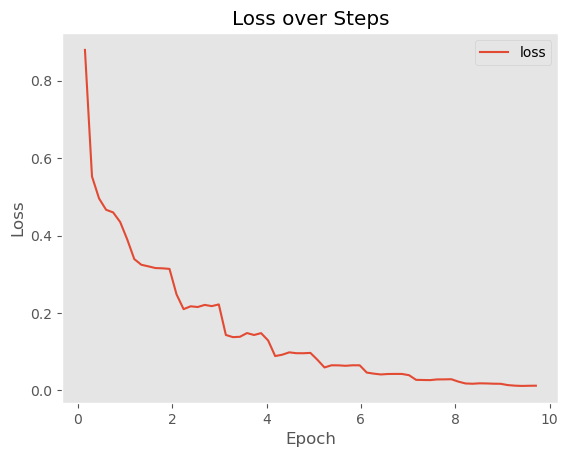

In [26]:

df.plot(x='epoch', y='loss', title='Loss over Steps')
plt.xlabel('Epoch')  
plt.ylabel('Loss')
plt.grid()
plt.show()